# CS446/519 Homework 1

Read in the metabolic network as a directed bipartite graph (hint: use `read_csv` from `pandas`)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from igraph import Graph
from igraph import summary
from igraph.statistics import power_law_fit
from igraph import WEAK, ALL

In [12]:
hsmet = pd.read_csv("shared/hsmetnet.txt", sep="\t", 
                    header=None, names=["ep1", "ep2"])
hsmet.head()

,ep1,ep2
0,alkylated DNA,REACTION1
1,REACTION1,DNAn
2,REACTION1,alkylated nucleobase
3,acetyl-CoA,REACTION2
4,1-alkyl-2-lyso-sn-glycero-3-phosphocholine,REACTION2


Get the names of all vertices and get a list of indexes of vertices that are metabolites (hint: use `Graph.TupleList` with `directed=True`; you can use  `.values.tolist()` on the Pandas dataframe

In [13]:
g_hsmet = Graph.TupleList(hsmet.values.tolist(), directed=True)
summary(g_hsmet)

IGRAPH DN-- 7879 19708 -- 
+ attr: name (v)


How many distinct metabolites are there in the graph? How many reactions? How many edges are there? (hint: use `in`, `for`, `len`, `str`, `set`, and `shape`)# print(len(mask_k_2))

In [14]:
v_names = pd.Series(g_hsmet.vs["name"]).drop_duplicates()
is_reaction = v_names.str.startswith("REACTION")
n_reaction = sum(is_reaction)

print("number of distinct metabolites in the graph: {}".format(
        len(v_names) - n_reaction))
print("number of distinct reactions in the graph: {}".format(
        n_reaction))
print("number of edges in the graph: {}".format(
        hsmet.shape[0]))

number of distinct metabolites in the graph: 2340
number of distinct reactions in the graph: 5539
number of edges in the graph: 19708


What are the top six metabolites in terms of vertex degree in the graph? (hint: use `for`, `enumerate`, `sorted` (with `reverse=True`), and `lambda` or `itemgetter`)

In [15]:
v_seq = hsmet["ep1"].append(hsmet["ep2"])
mtb_seq = v_seq[~v_seq.str.startswith("REACTION")]
mtb_count = mtb_seq.value_counts(ascending=False)

print(mtb_count.head(6))

ATP                                           1202
ADP                                            967
phosphate                                      562
peptide                                        456
[protein]-(L-serine/L-threonine)               383
[protein] (L-serine/L-threonine) phosphate     383
dtype: int64


Plot the distribution of the degrees of these vertices, on log-log scale.  (hint: use `degree_distribution` in igraph, with `vertices=metabolite_inds`; use the `.bins()` method to get the bin counts out; you can use `pylab.plot` to plot)

   break1  break2  count
0     1.0     2.0    710
1     2.0     3.0    581
2     3.0     4.0    259
3     4.0     5.0    175
4     5.0     6.0     96


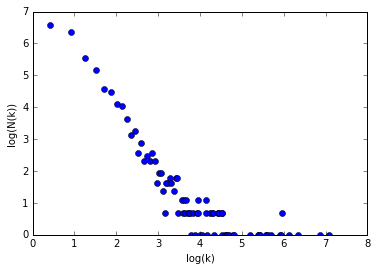

In [27]:
mtb_names = v_names[~is_reaction].tolist()
v_mtb = g_hsmet.vs.select(name_in = mtb_names)

deg_dist = g_hsmet.degree_distribution(vertices=v_mtb)

deg_dist_df = pd.DataFrame(deg_dist.bins(), 
                           columns=["break1", "break2", "count"])
print(deg_dist_df.head())

deg_breaks = (deg_dist_df["break1"] + deg_dist_df["break2"]) / 2
# "count" is a function name. `df.count` is ambiguous
deg_counts = deg_dist_df["count"] 

ax = plt.subplot(111)
plt.plot(np.log(deg_breaks.tolist()), np.log(deg_counts.tolist()), "o")
plt.xlabel("log(k)")
plt.ylabel("log(N(k))")
plt.show()

Calculate the exponent α of the best-fit power-law (hint: use `igraph.statistics.power_law_fit`)

In [17]:
fitted = power_law_fit(g_hsmet.degree())
print(fitted.summary())

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.023415
Cutoff (xmin)     = 9.000000

Log-likelihood    = -1298.549972

H0: data was drawn from the fitted distribution

KS test statistic = 0.018684
p-value           = 0.999892

H0 could not be rejected at significance level 0.05


Calculate the shortest-path-length between all pairs of metabolites (vertices) in the giant weakly connected component of the graph, discarding direction information.  (hint: use `clusters` with `mode=weak` to get the giant weakly-connected component; then use `components.membership` and `enumerate` to get the giant component members; then use `igraph.shortest_paths` with `mode=igraph.ALL`, with
`source=<metabolite_vertex_indices>` and `target=<metabolite_vertex_indices>` to get the
all-pairs-shortest-paths.)

In [18]:
components = g_hsmet.clusters(mode=WEAK)
comp_mmb = components.membership

In [19]:
apsp = g_hsmet.shortest_paths(mode=ALL, source=v_mtb, target=v_mtb)

Calculate the average of the shortest-path-length between all pairs of metabolites in the giant (weakly connected) component of the network, by throwing away any shortest-paths distance value if it is infinite. (hint: Use `numpy.array`, `numpy.isfinite` and `numpy.mean` to get the mean distance.)

In [20]:
merged_apsp = np.array(list(itertools.chain(*apsp)))
merged_apsp = merged_apsp[np.isfinite(merged_apsp)]
np.mean(merged_apsp)

6.7936869574623433

Calculate the maximum of the shortest-path-length between all pairs of metabolites (throwing away infinite values, as before) in the giant (weakly connected) component of the network (i.e., you are calculating the diameter of the giant component). (hint: use `numpy.max` and `numpy.isfinite`)

In [21]:
np.max(merged_apsp)

18.0

Calculate the shortest-paths betweenness centrality for all metabolites in the network. Make sure you are doing this on the directed graph (hint: use the `betweenness` function with the `v=<vector of vertex indices>` and `directed=True` options)

In [22]:
btw = g_hsmet.betweenness(vertices=v_mtb, directed=True)

plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale. (hint:  use `numpy.array`, `numpy.where`, and `matplotlib.pyplot.scatter`)

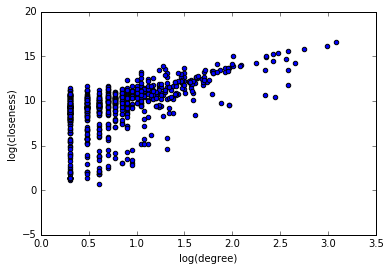

In [23]:
ax = plt.gca()
ax.scatter(np.log10(g_hsmet.degree(vertices=v_mtb, mode=ALL)), 
           np.log(btw))
plt.xlabel("log(degree)")
plt.ylabel("log(closeness)")
plt.show()

Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network? (hint:  use `numpy.argmax` and `numpy.where`.  Output should be "L-arginino-succinate"

In [24]:
mask_k_2 = (np.array(g_hsmet.degree(vertices=v_mtb, mode=ALL)) == 2)
v_mtb_k_2 = np.array(v_mtb.indices)[mask_k_2]
btw_k_2 = np.array(btw)[mask_k_2]

max_btw_id = np.argmax(btw_k_2)
max_v_id = v_mtb_k_2[max_btw_id]

print(g_hsmet.vs[max_v_id]["name"])

L-arginino-succinate
